### Strategy Selection

Chapter 7에서 label에서의 계열 조건성의 존재가 K-Fold Cross Validation을 어떻게 실패하게 하는지를 논의했는데, 이는 랜덤 샘플링이 중복된 관측값을 학습과 테스트셋에 이리저리 흩뿌리기 때문이다. 다른 검증 절차를 찾아야 한다. 즉, 모델을 훈련하는 데 사용되는 절차와 연관 혹은 중복될 가능성이 가장 작은 관측값으로 모델을 평가하는 검증 절차를 찾아야 한다.

scikit-learn은 walk-forward timefolds 기법을 구현하였다. 이 방법에서 테스트는 순방향으로 이동하는데 정보 누출을 막기 위한 목적을 갖고 있다. 이는 historical simulation이 수행되는 방식과 일치한다. 그러나 장기 시계열 종속이 있으면 훈련셋에서의 끝에서 하나 떨어진 관측값을 테스트하는 것만으로는 정보 누출을 충분히 피하지 못할 수 있다. 이 점은 나중에 다시 알아보자.



In [130]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import rankdata
from scipy.special import logit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Walk-Forward 기법의 한 가지 단점은 쉽게 과적합되는 것이다. 그 이유는 랜덤 샘플링을 하지 않고, False Positive가 나타날 때까지 계속반복하는 단일 테스트 경로이기 때문이다. 표준 Cross Validation처럼 이런 종류의 Performance Targeting이나 Backtest Optimization을 피하기 위해서는 랜덤화가 필요하며, 훈련 데이터셋에 상관된 예제로부터 테스트셋으로 정보가 누출되는 것을 막아야 한다. 다음으로 전략 선택에 있어 Probability of Bactesting Overfit에 기반을 둔 Cross Validation 기법을 소개한다. 백테스트에 대한 Cross Validation 기법의 설명은 Chapter 12에 소개한다.

Bailey 등(2017)에서는 Combinatory Symmetric Cross Validation을 통해 Probability of Backtest Overfit을 추정한다. 이 절차는 개략적으로 다음과 같다.

첫째, $N$회 시행으로부터 performance series를 수집해 행렬 $M$을 구성한다. 특히 각 열 $n = 1, \dots, N$은 연구자가 실험한 특정 모델 설정과 연계된 $t=1, \dots, T$ 관측값에 관한 손익 벡터를 나타낸다. 따라서 $M$은 $(T \times N)$ 차원 실수 행렬이다. 유일한 부과 조건은 다음과 같다.

1. $M$은 참 행렬이다. 즉 각 열에 대해 같은 수의 행을 찾고, $N$ 시행에 걸쳐 각 관측값은 모두 각 행에서 동시에 발생한다.
2. '최적' 전략을 고르고자 사용된 성과 평가 척도는 각 열의 부분 샘플에 대해서 추정할 수 있다. 

예를 들어, Sharpe Ratio를 척도로 사용했다면 보고된 성과의 여러 부분에 대해 $\text{IID}$ 정규 분포 가정이 성립한다고 할 수 있다. 여러 모델 설정이 여러 빈도로 거래 실행된다면 관측값을 통합해 공통 인덱스 $t = 1, \dots, T$에 맞춘다.

둘째, $M$을 행에 대해 분할해 서로 공통 원소가 없는 동일한 차원을 갖는 짝수 $S$개의 부분 행렬로 만든다. 각 부분 행렬 $M_S, s = 1, \dots, S$는 $\left(\frac{T}{S} \times N\right)$ 차원을 가진다.

셋째, $M_S$의 모든 조합 $C_S$를 크기 $\frac{S}{2}$의 그룹으로 만든다. 이를 통해 전체 조합 개수는 다음과 같아진다.

$$
\begin{pmatrix}
S \\ S/2
\end{pmatrix} = \begin{pmatrix} S-1 \\ S/2 -1 \end{pmatrix} \frac{S}{S/2} = \dots = \prod_{i=0}^{S/2 - 1}
$$

예를 들어, $S=16$이면 $12,780$ 조합이 형성된다. 각 조합 $c \in C_S$는 $\frac{S}{2}$ 부분 행렬 $M_S$로 구성된다.

넷째, 각 조합 $c \in C_S$에 대해 다음과 같이 한다.

1. $c$를 구성하는 $\frac{S}{2} M_S$ 부행렬을 조합해 훈련 데이터셋 $J$를 구성한다. $J$는 차수가 $\left(\frac{T}{S} \frac{S}{2} \times N\right) = \left(\frac{T}{2} \times N\right)$인 행렬이다.
2. $M$에서 $J$의 여집합으로 테스트셋 $\bar{J}$를 구성한다. 다시 말해 $\bar{J}$는 $J$의 일부가 아닌 $M$의 모든 행으로 구성된 $\left( \frac{T}{2} \times N\right)$행렬이다.
3. $N$차원 성과 통계량의 벡터 $R$을 구성한다. 여기서 $R$의 $n$번째 원소는 $J$의 $n$번째 열에 연관된 성과를 보고한다.
4. $R_n \leq R_{n^*}, \forall n=1, \dots, N$이 되는 원소 $n^*$을 결정한다. 다시 말해 $n^* = \arg \max_{n}\{R_n\}$이다.
5. $N$차원 성과 통계량의 벡터 $\bar{R}$을 구성하라. 여기서 $\bar{R}$의 $n$번째 원소는 $\bar{J}$의 $n$번째 열에 연관된 성과를 보여 준다.
6. $\bar{R}$ 내의 상대적 순위 $\bar{R_{n^*}}$을 결정하라. 이 상대적 순위를 $\bar{\omega}_c$라 표기한다. 여기서 $\bar{\omega}_c \in (0,1)$이다. 이는 샘플 내에서 선택된 시행과 연관된 샘플 외 성과의 상대적 순위다. 전략 최적화 절차가 과적합되지 않는다면 $R_{n^*}$이 $R$보다 성과가 뛰어난 것처럼 $\bar{R_{n^*}}$이 체계적으로 $R_{n^*}$ 성과가 뛰어난 것을 관찰한다.
7. Logit $\lambda_c = \log \left[ \frac{\bar{\omega}_c}{1 - \bar{\omega}_c}\right]$을 정의한다. 이는 $\bar{R_{n^*}}$이 $\bar{R}$의 중위값과 일치할 때 $\lambda_c = 0$의 성질을 보인다. 높은 로짓 값은 In sample과 Out of Sample 성과 사이의 일관성을 암시하며, 낮은 수준의 백테스트 과적합을 보인다.

다섯째, $c \in C_S$에 대해 모든 $\lambda_C$를 수집해 샘플 외의 순위 분포를 계산하라. 확률 분포 함수 $f(\lambda)$는 모든 $C_S$에 대해 $\int_{- \infty}^{\infty} f(\lambda)d\lambda = 1$로 나타나는 $\lambda$의 상대적 빈도로 추정된다. 마지막으로 $\text{PBO}$는 $\text{PBO} = \int_{-\infty}^0 f(\lambda)d \lambda$로 추정되는데, 이는 샘플 외보다 성과가 떨어지는 샘플 내 최적 전략과 연관된 확률이다.

In [131]:
def simulate_strategy_returns(n_strategies=100, n_periods=200, mean_range=(0, 0.03), sigma=0.02):
    means = np.random.uniform(*mean_range, n_strategies)
    returns = np.random.normal(loc=means[:, None], scale=sigma, size=(n_strategies, n_periods))
    return pd.DataFrame(returns.T)

In [132]:
def combinatorial_splits(S=16):
    idx = np.arange(S)
    half = S // 2
    splits = list(combinations(idx, half))
    pairs = [(train, tuple(set(idx)-set(train))) for train in splits]
    return pairs

In [133]:
from tqdm import tqdm

def estimate_pbo(returns_df, S=16):
    T, N = returns_df.shape
    chunk_size = T // S
    chunks = [returns_df.iloc[i*chunk_size:(i+1)*chunk_size] for i in range(S)]
    splits = combinatorial_splits(S)
    
    lambda_vals = []

    for train_idx, test_idx in tqdm(splits):
        train_data = pd.concat([chunks[i] for i in train_idx])
        test_data = pd.concat([chunks[i] for i in test_idx])
        
        train_sharpe = train_data.mean() / train_data.std()
        test_sharpe = test_data.mean() / test_data.std()
        
        best_strategy = train_sharpe.idxmax()
        
        test_rank = rankdata(-test_sharpe, method='average')[returns_df.columns.get_loc(best_strategy)]
        
        lambda_val = np.log(test_rank / N)
        lambda_vals.append(lambda_val)

    lambda_vals = np.array(lambda_vals)
    pbo = np.mean(lambda_vals < 0)
    
    return pbo, lambda_vals

In [139]:
returns = simulate_strategy_returns(
    n_strategies = 1000,
    n_periods = 252,
    mean_range = (-0.05, 0.03),
    sigma = 0.02
)

In [140]:
pbo, lambdas = estimate_pbo(returns, S = 16)

100%|██████████| 12870/12870 [00:24<00:00, 521.23it/s]


In [141]:
print(f"Probability of Backtest Overfitting (PBO): {pbo:.2%}")

Probability of Backtest Overfitting (PBO): 100.00%


In [142]:
from scipy.stats import norm

lambda_vals = np.exp(lambdas) / (1 + np.exp(lambdas))
logit_lambda = np.log(lambda_vals / (1 - lambda_vals))

prob_overfit = np.mean(logit_lambda < 0)

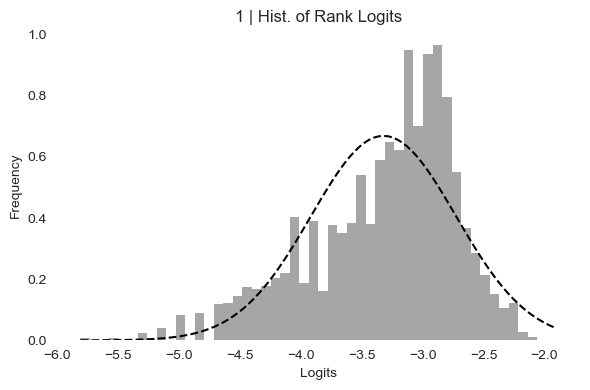

In [160]:
from sklearn.metrics import roc_curve

mu, std = norm.fit(logit_lambda[np.isfinite(logit_lambda)])
x = np.linspace(logit_lambda.min(), logit_lambda.max(), 100)
p = norm.pdf(x, mu, std)

fig, ax = plt.subplots(figsize = (6, 4))
ax.hist(
    logit_lambda, 
    bins=50, 
    density=True, 
    color='gray', 
    alpha=0.7, 
    edgecolor='none'
)
ax.plot(x, p, 'k--', linewidth=1.5)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xlabel("Logits")
plt.ylabel("Frequency")
plt.title("1 | Hist. of Rank Logits")

plt.grid(False)
plt.tight_layout()
plt.show()

위 그림의 $X$축은 선택된 최적 전략으로부터의 샘플 내의 Sharpe Ratio, $y$축은 선택된 동일한 최적 전략에 대한 샘플 외의 Sharpe Ratio를 보여 준다. 백테스트 과적합 때문에 야기된 강하고도 일관된 성과 저하가 보인다. 앞의 알고리즘을 적용하면 위 그림에서와 같이 전략 선택 프로세스와 연관된 $\text{PBO}$를 도출할 수 있다. 

각 부분 집합의 관측값은 원래의 시간 시퀀스를 유지하고 있다. 랜덤 샘플링은 관측이 아니라 상대적으로 상관관게가 없는 부분 집합들에 대해서 수행된다. 이 기법의 정확도 실험 분석에 대해서는 Bailey(2017)를 참고하자.